In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from custom import weather

matplotlib.rcParams['font.family'] = ['PingFang HK']
def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)
def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

%load_ext autoreload
%autoreload 2

In [3]:
#load station information
df = pd.read_csv('all_station_20201126.csv')
df.shape

(608, 16)

In [4]:
#load weather records
df_record = pd.read_pickle('weather_allstation_20150101-20201227.bz2')

In [5]:
## get a subset of data from Dec 2020, and only the precipitation column
df_sub = df_record.loc[pd.IndexSlice[:, '2020-12':], 'Precp']

In [6]:
df_w = df_sub.apply(pd.to_numeric, errors='coerce')
df_w.index.names = ['stn_code', 'date']
## remove the trailing empty records
df_w.dropna(how='all', inplace=True)

In [7]:
missing = df_w.isna().groupby('stn_code').sum()
missing_codes = missing[missing>0].index
df[df.stn_code.isin(missing_codes)]

Empty DataFrame
Columns: [stn_code, stn_name, altitude, Longitude, Latitude, city, address, data_start_date, stn_end_date, comment, orig_stn_code, new_stn_code, data_start_date2, data_duration, data_duration2, data_period]
Index: []

In [8]:
df_w.index.get_level_values(0).unique()

Index(['466880', '466900', '466910', '466920', '466930', '466940', '466950',
       '466990', '467050', '467060',
       ...
       'C1V600', 'C1V780', 'C1X040', 'C1Z030', 'C1Z040', 'C1Z110', 'C1Z120',
       'C1Z130', 'C1Z140', 'C1Z240'],
      dtype='object', name='stn_code', length=603)

In [9]:
df_w

stn_code  date      
466880    2020-12-01    16.5
          2020-12-02     6.0
          2020-12-03     7.0
          2020-12-04     2.5
          2020-12-08     3.5
                        ... 
C1Z240    2020-12-23    24.5
          2020-12-24    23.0
          2020-12-25     9.5
          2020-12-26     0.0
          2020-12-27     6.5
Name: Precp, Length: 16160, dtype: float64

In [10]:
df_combined = pd.merge(df.iloc[:, :5], df_w.reset_index(), how='inner', on='stn_code').set_index('date')
df_combined

stn_code stn_name  altitude   Longitude   Latitude  Precp
date                                                                
2020-12-01   466880       板橋       9.7  121.442017  24.997647   16.5
2020-12-02   466880       板橋       9.7  121.442017  24.997647    6.0
2020-12-03   466880       板橋       9.7  121.442017  24.997647    7.0
2020-12-04   466880       板橋       9.7  121.442017  24.997647    2.5
2020-12-08   466880       板橋       9.7  121.442017  24.997647    3.5
...             ...      ...       ...         ...        ...    ...
2020-12-23   C1Z240     中平林道    1163.0  121.267630  23.421150   24.5
2020-12-24   C1Z240     中平林道    1163.0  121.267630  23.421150   23.0
2020-12-25   C1Z240     中平林道    1163.0  121.267630  23.421150    9.5
2020-12-26   C1Z240     中平林道    1163.0  121.267630  23.421150    0.0
2020-12-27   C1Z240     中平林道    1163.0  121.267630  23.421150    6.5

[16160 rows x 6 columns]

In [11]:
temp = df_combined.loc['2020-12-01']

In [12]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage

# Setup
precp_mean = temp.Precp.mean()
precp_std  = temp.Precp.std()
precp_min = temp.Precp.min()
precp_max = temp.Precp.max()
debug     = False

In [13]:
precp_mean, precp_std, precp_min, precp_max

(10.908026755852843, 34.68798327042763, 0.0, 300.5)

In [158]:
import colorcet as cc

cmap = cc.rainbow

In [201]:
import matplotlib as mpl
# set upper part: 4 * 256/4 entries
upper = cc.cm.rainbow(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# lower =np.repeat([[1.,1.,1.,0.]], int(256/4), axis=0)
lower[0] = [1., 1., 1., 0.]

In [202]:
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(4):
  lower[:,i] = np.linspace(lower[0,i], upper[0,i], lower.shape[0])

In [203]:
lower

array([[1.        , 1.        , 1.        , 0.        ],
       [0.98412698, 0.98742143, 0.99962413, 0.01587302],
       [0.96825397, 0.97484286, 0.99924825, 0.03174603],
       [0.95238095, 0.96226429, 0.99887238, 0.04761905],
       [0.93650794, 0.94968571, 0.99849651, 0.06349206],
       [0.92063492, 0.93710714, 0.99812063, 0.07936508],
       [0.9047619 , 0.92452857, 0.99774476, 0.0952381 ],
       [0.88888889, 0.91195   , 0.99736889, 0.11111111],
       [0.87301587, 0.89937143, 0.99699302, 0.12698413],
       [0.85714286, 0.88679286, 0.99661714, 0.14285714],
       [0.84126984, 0.87421429, 0.99624127, 0.15873016],
       [0.82539683, 0.86163571, 0.9958654 , 0.17460317],
       [0.80952381, 0.84905714, 0.99548952, 0.19047619],
       [0.79365079, 0.83647857, 0.99511365, 0.20634921],
       [0.77777778, 0.8239    , 0.99473778, 0.22222222],
       [0.76190476, 0.81132143, 0.9943619 , 0.23809524],
       [0.74603175, 0.79874286, 0.99398603, 0.25396825],
       [0.73015873, 0.78616429,

In [204]:
# combine parts of colormap
cmap_raw = np.vstack(( lower, upper ))
nc = cmap_raw.shape[0]
nc

320

In [205]:
# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap_raw, name='myColorMap', N=nc)

chex = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(nc)]
cmap2 = [cmap(i) for i in range(nc)]

In [206]:
cmap2

[(1.0, 1.0, 1.0, 0.0),
 (0.9841269841269842,
  0.9874214285714286,
  0.999624126984127,
  0.015873015873015872),
 (0.9682539682539683,
  0.9748428571428571,
  0.999248253968254,
  0.031746031746031744),
 (0.9523809523809523,
  0.9622642857142857,
  0.998872380952381,
  0.047619047619047616),
 (0.9365079365079365,
  0.9496857142857142,
  0.9984965079365079,
  0.06349206349206349),
 (0.9206349206349207,
  0.9371071428571429,
  0.998120634920635,
  0.07936507936507936),
 (0.9047619047619048,
  0.9245285714285714,
  0.9977447619047619,
  0.09523809523809523),
 (0.8888888888888888, 0.91195, 0.9973688888888889, 0.1111111111111111),
 (0.873015873015873,
  0.8993714285714286,
  0.9969930158730159,
  0.12698412698412698),
 (0.8571428571428572,
  0.8867928571428572,
  0.9966171428571429,
  0.14285714285714285),
 (0.8412698412698413,
  0.8742142857142857,
  0.9962412698412698,
  0.15873015873015872),
 (0.8253968253968254,
  0.8616357142857143,
  0.9958653968253968,
  0.1746031746031746),
 (0.8095

In [207]:
# Setup colormap
# colors = chex
# colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
# vmin   = precp_mean - 2 * precp_std
# vmax   = precp_mean + 2 * precp_std
vmin = temp.Precp.min()
vmax = temp.Precp.max()
levels = len(chex)
cm     = branca.colormap.LinearColormap(cmap2, vmin=vmin, vmax=vmax).to_step(levels)
cm

In [208]:
cm(0)

'#ffffff00'

In [209]:
# Create a dataframe with fake data
# df = pd.DataFrame({
#     'longitude':   np.random.normal(11.84,     0.15,     1000),
#     'latitude':    np.random.normal(55.55,     0.15,     1000),
#     'temperature': np.random.normal(temp_mean, temp_std, 1000)})

# The original data
x_orig = np.asarray(temp.Longitude.tolist())
y_orig = np.asarray(temp.Latitude.tolist())
z_orig = np.asarray(temp.Precp.tolist())

n=500
# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), n)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), n)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

In [210]:
# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear', fill_value=0)

In [211]:
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

In [212]:
def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1 / (dist**3)

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

In [213]:
grid1 = simple_idw(x_orig, y_orig, z_orig, x_mesh.flatten(), y_mesh.flatten())
grid1 = grid1.reshape((n, n))

In [214]:
# ### Gaussian filter the grid to make it smoother
# sigma = [1, 1]
# z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')

In [216]:
# Create the contour
%matplotlib widget

contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=1, colors=cmap2, linestyles='None', vmin=0, vmax=vmax)
plt.plot(temp.Longitude, temp.Latitude, 'ro', alpha=0.2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [217]:
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=6,
    stroke_width=1,
    fill_opacity=0.5)

# Set up the folium plot
geomap = folium.Map([temp.Latitude.mean(), temp.Longitude.mean()], zoom_start=8, tiles="openstreetmap")

# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)

# Add the colormap to the folium map
cm.caption = 'Precipitation'
geomap.add_child(cm)

# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
geomap

## try constrained(limited distance) interpolation

In [218]:
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

# Construct kd-tree, functionality copied from scipy.interpolate
xy = np.array(list(zip(x_orig, y_orig)))
tree = cKDTree(xy)

In [219]:
xy.shape

(598, 2)

In [220]:
xi = _ndim_coords_from_arrays((x_mesh, y_mesh), ndim=xy.shape[1])

In [221]:
dists, indexes = tree.query(xi)

In [222]:
z_mesh.shape

(500, 500)

In [223]:
np.round(np.linspace(0, 256, 12)).astype('int')

array([  0,  23,  47,  70,  93, 116, 140, 163, 186, 209, 233, 256])

In [226]:
lower[0,2]

1.0

In [227]:
# Copy original result but mask missing values with NaNs
THRESHOLD = 0.08
z_mesh2 = z_mesh.copy()
z_mesh2[dists > THRESHOLD] = np.nan

### Gaussian filter the grid to make it smoother
sigma = [0.5, 0.5]
z_mesh3 = sp.ndimage.filters.gaussian_filter(z_mesh2, sigma, mode='constant')

# Create the contour
%matplotlib widget
upper = cc.cm.rainbow(np.round(np.linspace(0, 256, 12)).astype('int'))
lower = np.ones((int(12/4),4))
lower[0,3] = 0.
for i in range(3):
  lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

cmap_raw = np.vstack(( lower, upper ))
nc = cmap_raw.shape[0]
cmap = mpl.colors.ListedColormap(cmap_raw, name='myColorMap', N=nc)
# chex = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(nc)]
cmap2 = [cmap(i) for i in range(nc)]
levels = len(cmap2)
cmap2

[(1.0, 1.0, 1.0, 0.0),
 (0.5, 0.603775, 0.9881599999999999, 1.0),
 (0.0, 0.20755, 0.97632, 1.0),
 (0.0, 0.20755, 0.97632, 1.0),
 (0.0, 0.39667, 0.71405, 1.0),
 (0.18517, 0.51246, 0.4737, 1.0),
 (0.24679, 0.60693, 0.23472, 1.0),
 (0.38629, 0.681, 0.055243, 1.0),
 (0.60581, 0.73251, 0.088583, 1.0),
 (0.81244, 0.78108, 0.12327, 1.0),
 (0.9802, 0.79159, 0.14055, 1.0),
 (1.0, 0.6718, 0.087465, 1.0),
 (1.0, 0.53942, 0.023487, 1.0),
 (1.0, 0.38075, 0.0, 1.0),
 (1.0, 0.16528, 0.0, 1.0)]

In [237]:
%matplotlib widget
contourf = plt.contourf(x_mesh, y_mesh, z_mesh3, levels, alpha=1, colors=cmap2, linestyles='None', vmin=0, vmax=vmax)
plt.plot(temp.Longitude, temp.Latitude, 'ro', alpha=0.2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [231]:
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=None,
    ndigits=5,
    stroke_width=0,
    fill_opacity=1)

In [232]:
import json
parsed_json = (json.loads(geojson))

In [233]:
parsed_json['features'][0]['properties'].keys()

dict_keys(['fill', 'fill-opacity', 'stroke', 'stroke-opacity', 'stroke-width', 'title'])

In [238]:
parsed_json['features'][0]['properties']

{'fill': '#ffffff',
 'fill-opacity': 1,
 'stroke': '#ffffff',
 'stroke-opacity': 1,
 'stroke-width': 0,
 'title': '0.00-20.00 '}

In [240]:
# Set up the folium plot
geomap = folium.Map([temp.Latitude.mean(), temp.Longitude.mean()], zoom_start=8, tiles="openstreetmap")

# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
#         'weight': 0,
        'fillColor': x['properties']['fill'],
        'fillOpacity': 0. if x['properties']['fill']=='#ffffff' else .7,
    }).add_to(geomap)

# Add the colormap to the folium map
cm.caption = 'Precipitation'
geomap.add_child(cm)

# Fullscreen mode
# plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
geomap

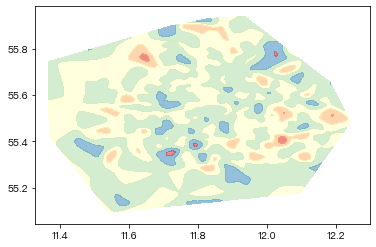

In [88]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage

# Setup
temp_mean = 12
temp_std  = 2
debug     = False

# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)

# Create a dataframe with fake data
df = pd.DataFrame({
    'longitude':   np.random.normal(11.84,     0.15,     1000),
    'latitude':    np.random.normal(55.55,     0.15,     1000),
    'temperature': np.random.normal(temp_mean, temp_std, 1000)})

# The original data
x_orig = np.asarray(df.longitude.tolist())
y_orig = np.asarray(df.latitude.tolist())
z_orig = np.asarray(df.temperature.tolist())

# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')

# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')

# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)

# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)

# Set up the folium plot
geomap = folium.Map([df.latitude.mean(), df.longitude.mean()], zoom_start=10, tiles="cartodbpositron")

# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)

# Add the colormap to the folium map
cm.caption = 'Temperature'
geomap.add_child(cm)

# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)

In [89]:
geomap

In [45]:
# Plot the data
geomap.save(f'data/folium_contour_temperature_map.html')

In [87]:
!pip install geojsoncontour

     |████████████████████████████████| 736 kB 1.2 MB/s eta 0:00:01
